# Use Pope et al. (2008) k-means classification technique on ARM sounding data. Uses 5 clusters.

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
from datetime import datetime, timedelta
import glob
from copy import deepcopy
import math
from pymeteo import skewt
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
data_path_sounding = '/home/rjackson/data/soundings/'

In [4]:
# get_sounding)times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of sounding times between start_time and end_time. 
# Only 23 UTC is loaded following Pope et al. (2008)
def get_sounding_times(start_year, start_month, start_day,
                       start_hour, start_minute, end_year,
                       end_month, end_day, end_hour, 
                       end_minute, minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )
    deltatime = end_time - start_time

    if(deltatime.seconds > 0 or deltatime.minutes > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load sounding files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time

    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_sounding +
                      'twpsondewnpnC3.b1.' +
                      year_str +
                      month_str +
                      day_str +
                      '*.23*'
                     '*custom.cdf')
    
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
        
   
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-11]  
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
                
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
               
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_sounding(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_sounding +
                     'twpsondewnpnC3.b1.' +
                     year_str +
                     month_str +
                     day_str +
                     '.' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.custom.cdf')
    sounding = Dataset(file_name_str, mode='r')
    return sounding

Load netCDF sounding data

surface (assumed
here to be 1013 hPa), 950, 925, 900, 850, 800, 750, 700,
650, 600, 550, 500, 400, 300, 200, and 100 hPa (a total of
16 levels)

In [5]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

Here is where we input the times and pressure levels to get sounding from.

In [187]:
start_year = 2002
end_year = 2015

sounding_times = get_sounding_times(start_year,1,1,0,1,
                                    end_year,1,1,23,1)

pres_levels = [1013, 950, 925, 900, 850, 800, 750, 700, 
               650, 600, 550, 500, 400, 300, 200, 100]
print(len(sounding_times))

We are about to load sounding files for 4749 days
Looking for files with format /home/rjackson/data/soundings/twpsondewnpnC3.b1.20020101*.23**custom.cdf
Looking for files with format /home/rjackson/data/soundings/twpsondewnpnC3.b1.20020411*.23**custom.cdf
Looking for files with format /home/rjackson/data/soundings/twpsondewnpnC3.b1.20020720*.23**custom.cdf
Looking for files with format /home/rjackson/data/soundings/twpsondewnpnC3.b1.20021028*.23**custom.cdf
Looking for files with format /home/rjackson/data/soundings/twpsondewnpnC3.b1.20030205*.23**custom.cdf
Looking for files with format /home/rjackson/data/soundings/twpsondewnpnC3.b1.20030516*.23**custom.cdf
Looking for files with format /home/rjackson/data/soundings/twpsondewnpnC3.b1.20030824*.23**custom.cdf
Looking for files with format /home/rjackson/data/soundings/twpsondewnpnC3.b1.20031202*.23**custom.cdf
Looking for files with format /home/rjackson/data/soundings/twpsondewnpnC3.b1.20040311*.23**custom.cdf
Looking for files with 

Loop over all of the soundings.

In [188]:
## Save soundings at 16 levels for later

u_soundings = np.zeros((len(sounding_times),16))
v_soundings = np.zeros((len(sounding_times),16))
t_soundings = np.zeros((len(sounding_times),16))
z_soundings = np.zeros((len(sounding_times),16))
dp_soundings = np.zeros((len(sounding_times),16))
time_soundings = []
pres_soundings = np.zeros((len(sounding_times),16))
count = 0

for time in sounding_times:
    if(time.month <= 4 or time.month >= 9):
        if(time.hour == 23):
            pres_index = []
            # Load sounding file
            Sounding_netcdf = get_sounding(time)

            # Convert timestamps to datetime format        
            p = Sounding_netcdf.variables['pres'][:]
            u = Sounding_netcdf.variables['u_wind'][:]
            v = Sounding_netcdf.variables['v_wind'][:]
            t = Sounding_netcdf.variables['tdry'][:]
            z = Sounding_netcdf.variables['alt'][:]
            dp = Sounding_netcdf.variables['dp'][:]
            
            # Take levels from the sounding and place them into the array
            
            for pres in pres_levels:
                pres_index.append(find_nearest(p,pres))
           
            
            # Check for availability of 16 pressure levels
            good_sounding = 1
            for i in range(0,len(pres_levels)-1):
                if(p[pres_index[i]] < pres_levels[i]-20 or
                   p[pres_index[i]] > pres_levels[i]+20):
                    good_sounding = 0
                if(abs(u[pres_index[i]]) > 75 or
                   abs(v[pres_index[i]]) > 75):
                    good_sounding = 0
            
            u = u[pres_index]
            v = v[pres_index]
            t = t[pres_index]
            z = z[pres_index]
            dp = dp[pres_index]
            
            for i in range(0,len(u)):
                if(u[i] < -75 or v[i] < -75 or
                   u[i] is np.ma.masked or
                   v[i] is np.ma.masked or
                   dp[i] is np.ma.masked or
                   t[i] is np.ma.masked or
                   dp[i] < -99):
                    good_sounding = 0
            
            if(t[0] < 0):
                t[:] = float('nan')
                good_sounding = 0
                
            # If pressure levels are not available, mask the entire sounding
            if(good_sounding == 0):
                print('Sounding ' + str(count) + ' masked')
            else:    
                u_soundings[count][:] = u
                v_soundings[count][:] = v
                t_soundings[count][:] = t
                dp_soundings[count][:] = dp
                z_soundings[count][:] = z
                time_soundings.append(time)
                pres_soundings[count][:] = pres_levels
                count = count + 1   
                
    if(count % 100 == 0):
        print(time)

u_soundings = u_soundings[0:count-1][:]
v_soundings = v_soundings[0:count-1][:]
t_soundings = t_soundings[0:count-1][:]
dp_soundings = dp_soundings[0:count-1][:]
z_soundings = z_soundings[0:count-1][:]
pres_soundings = pres_soundings[0:count-1][:]

Sounding 22 masked
Sounding 27 masked
Sounding 35 masked
Sounding 36 masked
Sounding 38 masked
Sounding 41 masked
Sounding 45 masked
Sounding 58 masked
Sounding 59 masked
Sounding 72 masked
Sounding 82 masked
Sounding 83 masked
Sounding 87 masked
Sounding 94 masked
Sounding 97 masked
2002-12-01 23:17:00
Sounding 101 masked
Sounding 110 masked
Sounding 127 masked
Sounding 132 masked
Sounding 140 masked
Sounding 140 masked
Sounding 140 masked
Sounding 140 masked
Sounding 143 masked
Sounding 143 masked
Sounding 148 masked
Sounding 148 masked
Sounding 148 masked
Sounding 148 masked
Sounding 153 masked
Sounding 171 masked
Sounding 181 masked
Sounding 181 masked
2003-04-03 23:15:00
Sounding 201 masked
Sounding 203 masked
Sounding 205 masked
Sounding 216 masked
Sounding 219 masked
Sounding 222 masked
Sounding 254 masked
Sounding 266 masked
Sounding 268 masked
Sounding 269 masked
Sounding 273 masked
Sounding 281 masked
Sounding 281 masked
Sounding 282 masked
Sounding 286 masked
Sounding 289 ma

Do k-means clustering.

In [189]:
Kmeans_array = np.zeros((count-1,60))
#u_soundings = ma.masked_where(abs(u_soundings) > 75, u_soundings)
#v_soundings = ma.masked_where(abs(v_soundings) > 75, v_soundings)
#dp_soundings = ma.masked_where(dp_soundings < -100, dp_soundings)
#t_soundings = ma.masked_where(t_soundings < -100, t_soundings)
#u_soundings.fill_value = float('nan')
#v_soundings.fill_value = float('nan')
#dp_soundings.fill_value = float('nan')
#t_soundings.fill_value = float('nan')

Kmeans_array[:,0:16] = u_soundings
Kmeans_array[:,16:32] = v_soundings
Kmeans_array[:,32:48] = t_soundings
Kmeans_array[:,48:60] = dp_soundings[:,0:12]
#Kmeans_array = scale(Kmeans_array)

kmeans = KMeans(init='k-means++', n_clusters=5, n_init=20)
kmeans.fit(Kmeans_array)

groups = kmeans.predict(Kmeans_array)

u_mean0 = kmeans.cluster_centers_[0][0:16]
v_mean0 = kmeans.cluster_centers_[0][16:32]
t_mean0 = kmeans.cluster_centers_[0][32:48]
z_mean0 = ma.mean(z_soundings[groups == 0,:], axis=0)
dp_mean0 = kmeans.cluster_centers_[0][48:60]
pres_mean0 = ma.mean(pres_soundings[groups == 0,:], axis=0)

u_mean1 = kmeans.cluster_centers_[1][0:16]
v_mean1 = kmeans.cluster_centers_[1][16:32]
t_mean1 = kmeans.cluster_centers_[1][32:48]
z_mean1 = ma.mean(z_soundings[groups == 1,:], axis=0)
dp_mean1 = kmeans.cluster_centers_[1][48:60]
pres_mean1 = ma.mean(pres_soundings[groups == 1,:], axis=0)

u_mean2 = kmeans.cluster_centers_[2][0:16]
v_mean2 = kmeans.cluster_centers_[2][16:32]
t_mean2 = kmeans.cluster_centers_[2][32:48]
z_mean2 = ma.mean(z_soundings[groups == 2,:], axis=0)
dp_mean2 = kmeans.cluster_centers_[2][48:60]
pres_mean2 = ma.mean(pres_soundings[groups == 2,:], axis=0)

u_mean3 = kmeans.cluster_centers_[3][0:16]
v_mean3 = kmeans.cluster_centers_[3][16:32]
t_mean3 = kmeans.cluster_centers_[3][32:48]
z_mean3 = ma.mean(z_soundings[groups == 3,:], axis=0)
dp_mean3 = kmeans.cluster_centers_[3][48:60]
pres_mean3 = ma.mean(pres_soundings[groups == 3,:], axis=0)

u_mean4 = kmeans.cluster_centers_[4][0:16]
v_mean4 = kmeans.cluster_centers_[4][16:32]
t_mean4 = kmeans.cluster_centers_[4][32:48]
z_mean4 = ma.mean(z_soundings[groups == 4,:], axis=0)
dp_mean4 = kmeans.cluster_centers_[4][48:60]
pres_mean4 = ma.mean(pres_soundings[groups == 4,:], axis=0)

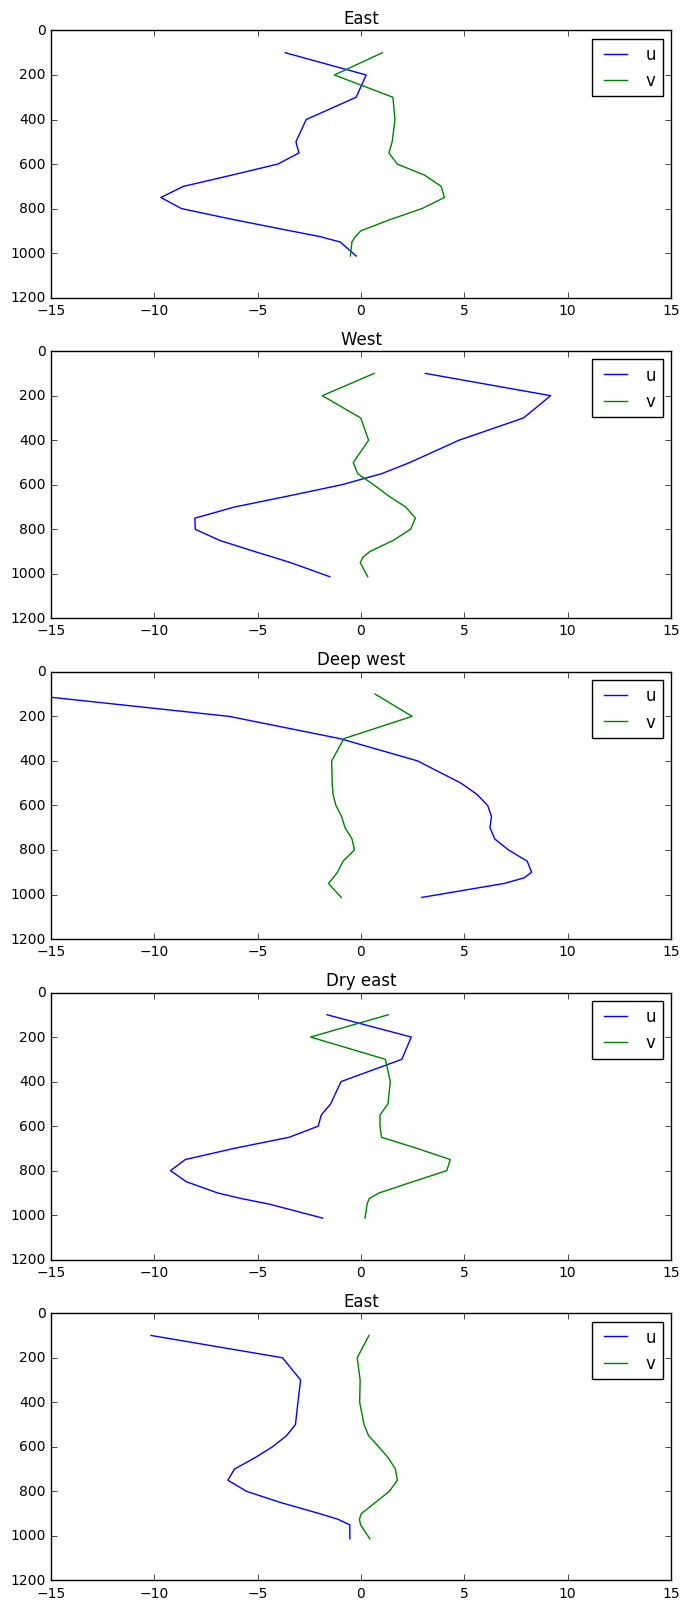

In [190]:
fig = plt.figure(figsize=(8,20))

plt.subplot(511)
axis = plt.axes
plt.plot(u_mean1,pres_levels)
plt.plot(v_mean1,pres_levels)
plt.gca().invert_yaxis()
plt.legend(('u', 'v'))
plt.xlim((-15, 15))
plt.title('East')

plt.subplot(512)
axis = plt.axes
plt.plot(u_mean2,pres_levels)
plt.plot(v_mean2,pres_levels)
plt.gca().invert_yaxis()
plt.legend(('u', 'v'))
plt.xlim((-15, 15))
plt.title('West')

plt.subplot(513)
axis = plt.axes
plt.plot(u_mean3,pres_levels)
plt.plot(v_mean3,pres_levels)
plt.gca().invert_yaxis()
plt.legend(('u', 'v'))
plt.xlim((-15, 15))
plt.title('Deep west')

plt.subplot(514)
axis = plt.axes
plt.plot(u_mean4,pres_levels)
plt.plot(v_mean4,pres_levels)
plt.gca().invert_yaxis()
plt.legend(('u', 'v'))
plt.xlim((-15, 15))
plt.title('Dry east')

plt.subplot(515)
axis = plt.axes
plt.plot(u_mean0,pres_levels)
plt.plot(v_mean0,pres_levels)
plt.gca().invert_yaxis()
plt.legend(('u', 'v'))
plt.xlim((-15, 15))
plt.title('East')

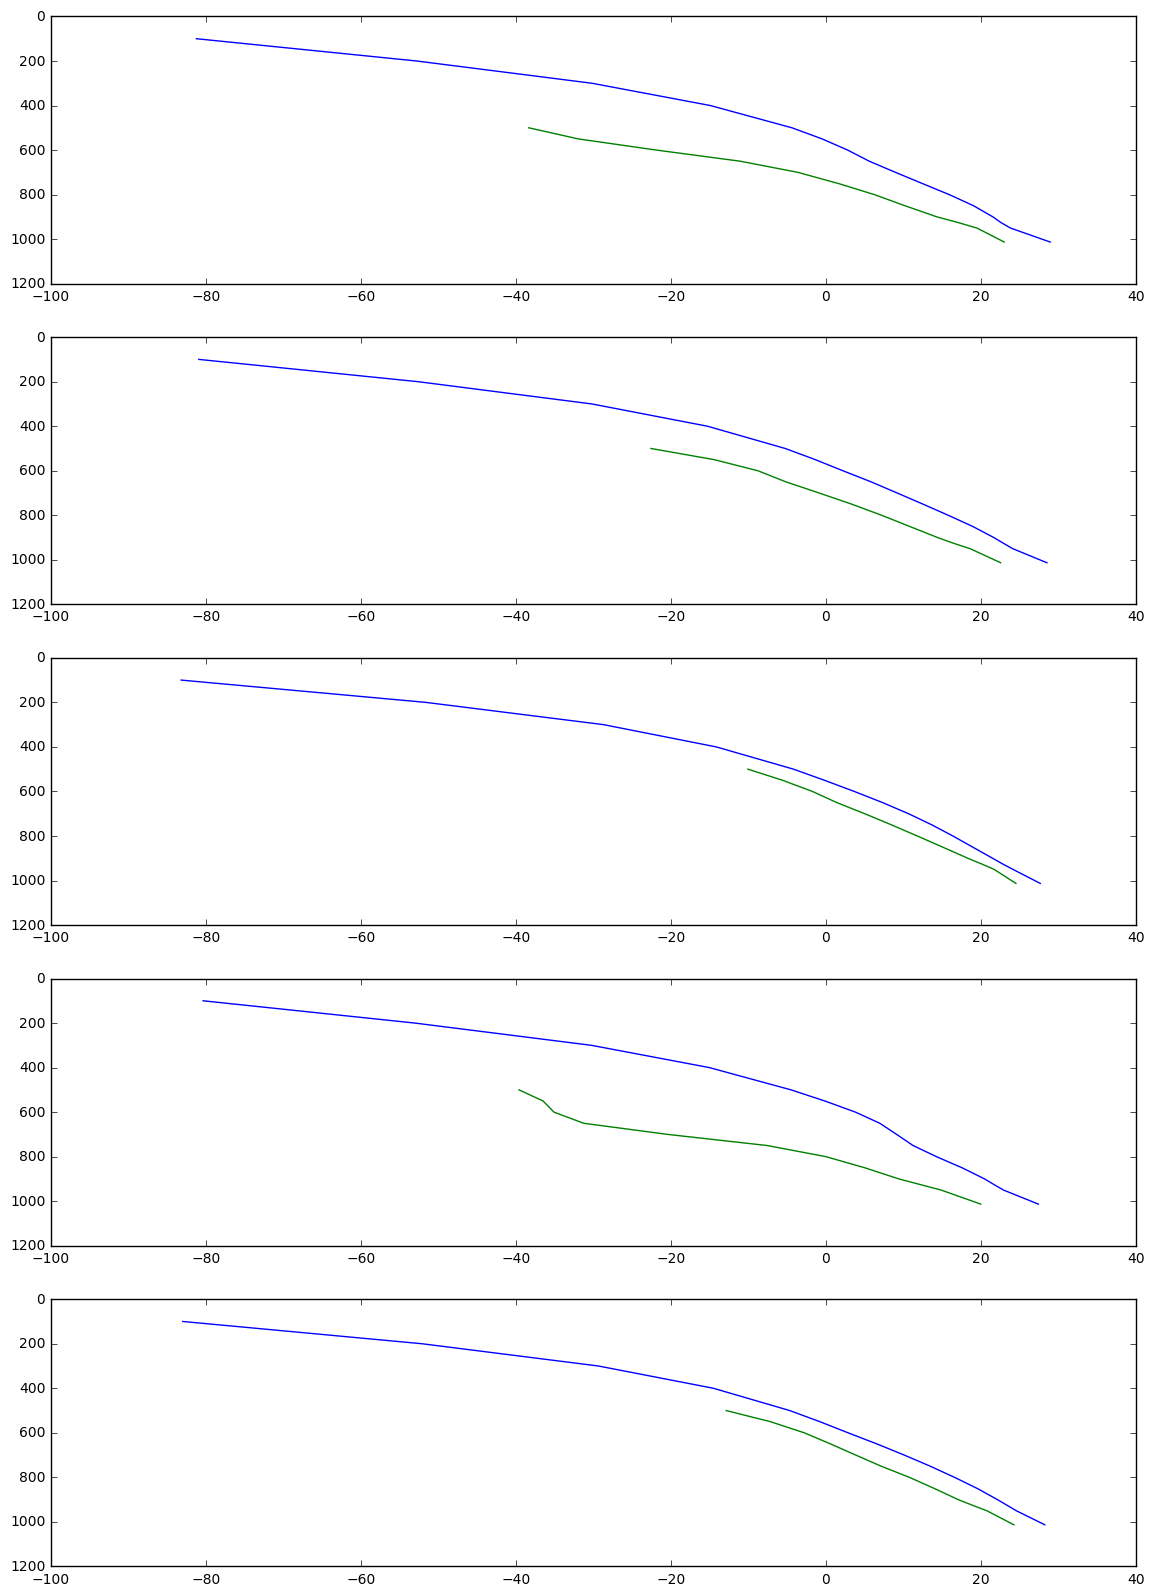

In [192]:
fig = plt.figure(figsize=(14,20))

plt.subplot(511)
axis = plt.axes
plt.plot(t_mean1,pres_levels)
plt.plot(dp_mean1,pres_levels[0:12])
plt.gca().invert_yaxis()

plt.subplot(512)
axis = plt.axes
plt.plot(t_mean2,pres_levels)
plt.plot(dp_mean2,pres_levels[0:12])
plt.gca().invert_yaxis()

plt.subplot(513)
axis = plt.axes
plt.plot(t_mean3,pres_levels)
plt.plot(dp_mean3,pres_levels[0:12])
plt.gca().invert_yaxis()

plt.subplot(514)
axis = plt.axes
plt.plot(t_mean4,pres_levels)
plt.plot(dp_mean4,pres_levels[0:12])
plt.gca().invert_yaxis()

plt.subplot(515)
axis = plt.axes
plt.plot(t_mean0,pres_levels)
plt.plot(dp_mean0,pres_levels[0:12])
plt.gca().invert_yaxis()